In [45]:
import datetime as dt
import numpy as np
import pandas as pd


from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [53]:
def get_data() -> pd.DataFrame:
    col_names = ['ScrapeTime','CardPos','FuelType','Station','Address','RawPrice','CondPrice']
    start_date = dt.date(2024, 4, 2)
    df = pd.read_csv('gas-scrape-data.csv', names=col_names, parse_dates=['ScrapeTime'])
    df['ScrapeDate'] = df['ScrapeTime'].dt.date
    df['StationAddress'] = df['Station'] + ' - ' + df['Address']
    return df[(~df['CondPrice'].isna()) & (df['ScrapeDate'] >= start_date)].copy()

def condition_data(df: pd.DataFrame):
    dates = df['ScrapeDate'].unique()
    fuel_types = df['FuelType'].unique()
    cond_pos = {}
    price_delta = {}
    for date in dates:
        for f_type in fuel_types:
            dff = df[(df['ScrapeDate'] == date) & (df['FuelType'] == f_type)].copy()
            min_pos = dff['CardPos'].min()
            min_price = dff['CondPrice'].min()
            f_type_cond_pos = dff['CardPos'] - min_pos
            f_type_delta_price = dff['CondPrice'] - min_price
            cond_pos.update(f_type_cond_pos)
            price_delta.update(f_type_delta_price)
    df['CondCardPos'] = df.index.map(cond_pos)
    df['PriceDelta'] = df.index.map(price_delta)
    
def get_condition_data() -> pd.DataFrame:
    df = get_data()
    condition_data(df)
    return df

df = get_condition_data()
df

,ScrapeTime,CardPos,FuelType,Station,Address,RawPrice,CondPrice,ScrapeDate,StationAddress,CondCardPos,PriceDelta
24,2024-04-02 11:30:13,5,regular,Murphy USA,"2635 Grand Ave|Carthage, MO",$3.02,3.02,2024-04-02,"Murphy USA - 2635 Grand Ave|Carthage, MO",0,0.00
25,2024-04-02 11:30:13,6,regular,Phillips 66,"2812 Hazel St|Carthage, MO",$3.06,3.06,2024-04-02,"Phillips 66 - 2812 Hazel St|Carthage, MO",1,0.04
26,2024-04-02 11:30:13,7,regular,Casey's,"2214 Fairlawn Ave|Carthage, MO",$3.19,3.19,2024-04-02,"Casey's - 2214 Fairlawn Ave|Carthage, MO",2,0.17
27,2024-04-02 11:30:13,8,regular,Casey's,"917 W Central Ave|Carthage, MO",$3.19,3.19,2024-04-02,"Casey's - 917 W Central Ave|Carthage, MO",3,0.17
28,2024-04-02 11:30:13,9,regular,Flyin W,"13011 MO-96|Carthage, MO",$3.19,3.19,2024-04-02,"Flyin W - 13011 MO-96|Carthage, MO",4,0.17
...,...,...,...,...,...,...,...,...,...,...,...
702,2024-05-01 11:30:12,6,diesel,The Corner,"824 E Fairview Ave|Carthage, MO",$3.69,3.69,2024-05-01,"The Corner - 824 E Fairview Ave|Carthage, MO",2,0.00
703,2024-05-01 11:30:12,7,diesel,Phillips 66,"201 E Central Ave|Carthage, MO",$3.69,3.69,2024-05-01,"Phillips 66 - 201 E Central Ave|Carthage, MO",3,0.00
707,2024-05-01 11:30:12,4,premium,Murphy USA,"2635 Grand Ave|Carthage, MO",$3.63,3.63,2024-05-01,"Murphy USA - 2635 Grand Ave|Carthage, MO",0,0.00
708,2024-05-01 11:30:12,5,premium,Phillips 66,"201 E Central Ave|Carthage, MO",$3.89,3.89,2024-05-01,"Phillips 66 - 201 E Central Ave|Carthage, MO",1,0.26


## Time Series of Lowest Fuel Price

In [47]:
def get_time_series_by_type_pos(df: pd.DataFrame, fuel_type: str, cond_pos=0) -> go.Scatter:
    dff = df[(df['FuelType'] == fuel_type) & (df['CondCardPos'] == 0)].copy()
    hover = '<b>Date: </b>' + dff['ScrapeTime'].dt.strftime('%m/%d/%Y') + '<br>' + '<b>Cost: </b>' + dff.RawPrice.astype(str) + \
        '<br>' + '<b>Station: </b>' + dff['Station'] + '<br>' + '<b>Address: </b>' + dff['Address'].str.replace('|','<br>', regex=False)
    dff['ScrapeTime'] = dff['ScrapeTime'].dt.date
    dff.set_index('ScrapeTime', inplace=True)
    return go.Scatter(
        x=dff.index,
        y=dff['CondPrice'],
        name=fuel_type,
        hovertemplate=hover
    )

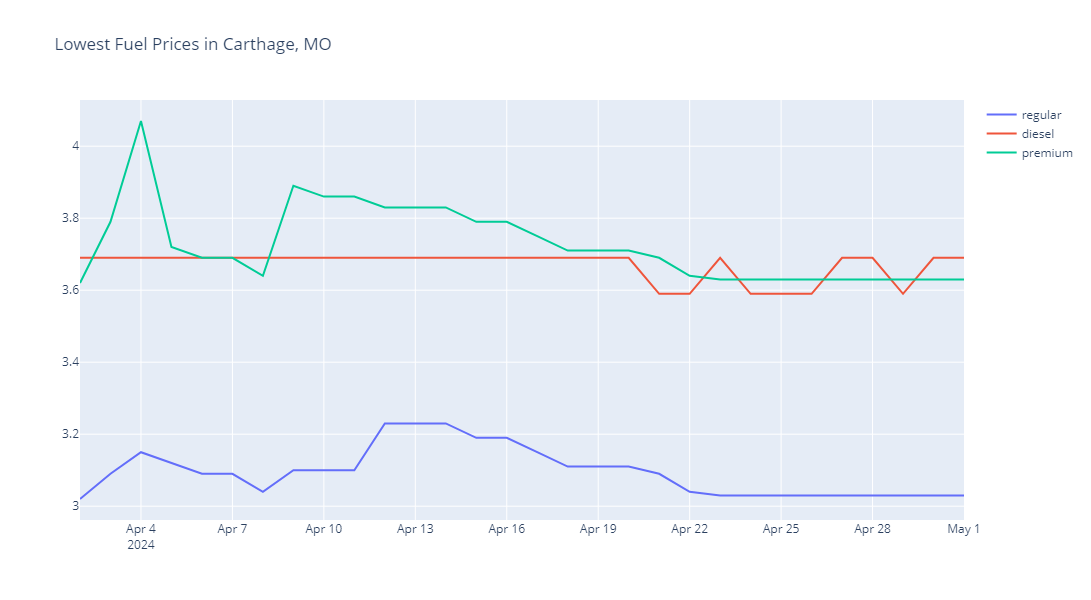

In [48]:
traces = []
for fuel_type in df['FuelType'].unique():
    traces.append(get_time_series_by_type_pos(df, fuel_type))

    
layout = {
    'height':600,
    #'yaxis': {'range':[3,4.2], 'dtick': 0.1},
    'title': {'text':'Lowest Fuel Prices in Carthage, MO'}
}
    
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

# Fuel Price by Station and Address

In [49]:
def get_data_by_fuel_type_address(df: pd.DataFrame, fuel_type: str, address: str) -> pd.DataFrame:
    return df[(df['FuelType'] == fuel_type) & (df['Address'] == address)].copy()
    
def get_time_series_by_fuel_type_address(df: pd.DataFrame, fuel_type: str, address: str) -> pd.DataFrame:
    dff = get_data_by_fuel_type_address(df, fuel_type, address)
    if dff.shape[0] == 0:
        return None
    
    dff['ScrapeTime'] = dff['ScrapeTime'].dt.date
    dff.set_index('ScrapeTime', inplace=True)
    return go.Scatter(
        x = dff.index,
        y = dff['CondPrice'],
        name=dff['StationAddress'].iloc[0].split('|')[0]
    )

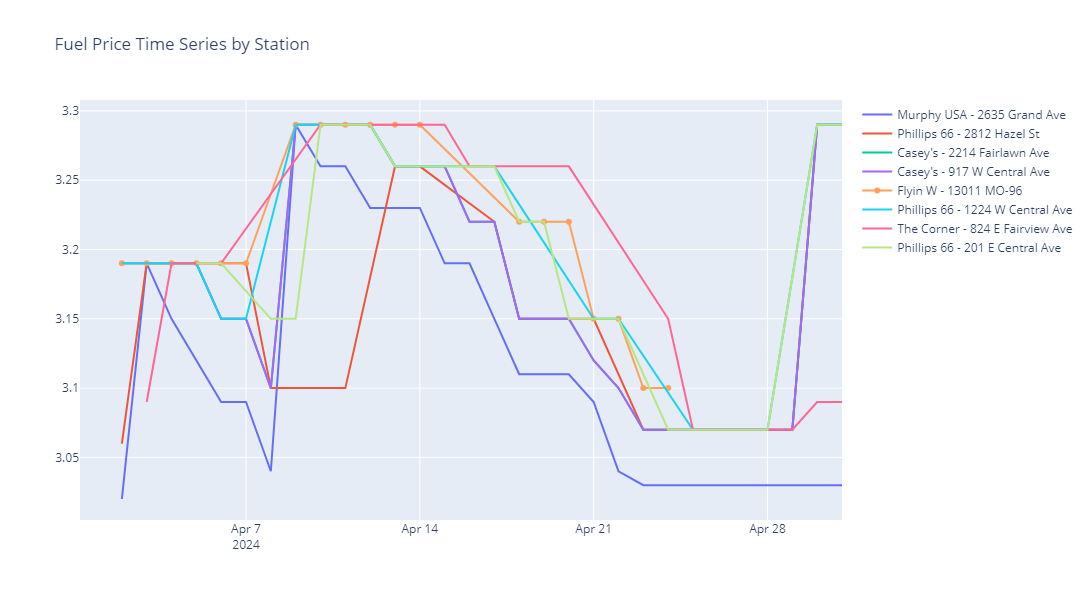

In [50]:
def build_fuel_type_station_traces(fuel_type: str) -> list:
    station_traces = []
    for address in df['Address'].unique():
        trace = get_time_series_by_fuel_type_address(df,fuel_type, address)
        if trace is None:
            continue
        station_traces.append(trace)
    return station_traces

station_traces = build_fuel_type_station_traces('regular')

layout = {
    'height':600,
    #'yaxis': {'range':[3,4.2], 'dtick': 0.1},
    'title': {'text':'Fuel Price Time Series by Station'},
    'hovermode':'x'
}
    
fig = go.Figure(data=station_traces, layout=layout)
iplot(fig)

# Max, Min, Average

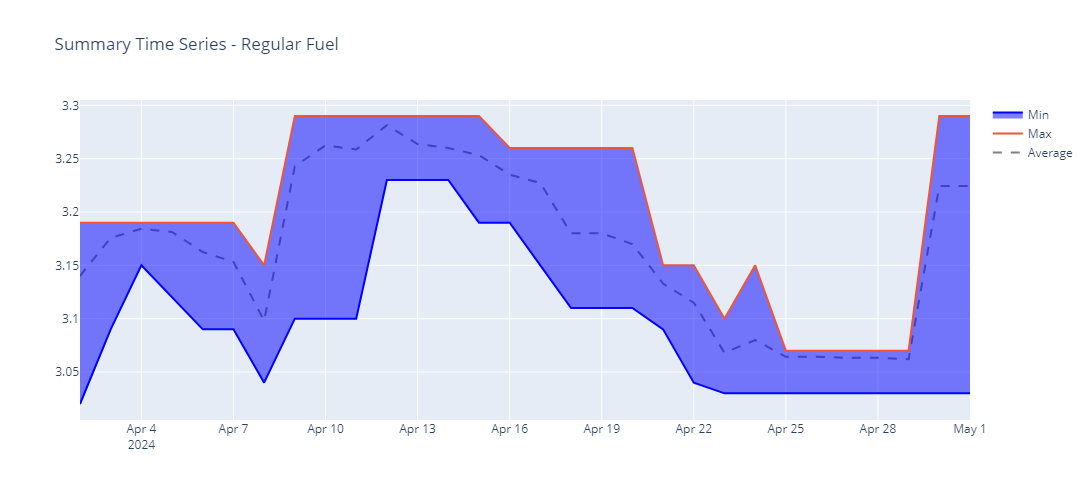

In [51]:
def compute_summary_time_series(df: pd.DataFrame, fuel_type: str) -> list:
    dff = df[df['FuelType'] == fuel_type].copy()
    dff['ScrapeTime'] = dff['ScrapeTime'].dt.date
    mean_price = dff.groupby('ScrapeTime')['CondPrice'].mean()
    max_price = dff.groupby('ScrapeTime')['CondPrice'].max()
    min_price = dff.groupby('ScrapeTime')['CondPrice'].min()
    traces = []
    traces.append(go.Scatter(x=mean_price.index, y=mean_price.values,name='Average', line_dash='dash', line_color='gray'))
    traces.append(go.Scatter(x=max_price.index, y=max_price.values,name='Max'))
    traces.append(go.Scatter(x=min_price.index, y=min_price.values,name='Min', fill='tonexty', line_color='blue'))
    return traces

layout = {
    'height':500,
    'title': {'text':'Summary Time Series - Regular Fuel'},
    'hovermode':'x'
}
fig = go.Figure(data=compute_summary_time_series(df, 'regular'), layout=layout)
iplot(fig)

In [60]:
qty_days = len(df['ScrapeDate'].unique())
for station in df['StationAddress'].unique():
    dff = df[(df['StationAddress'] == station) & (df['FuelType']  == 'regular')].copy()
    qty_lowest = np.where(dff['CondCardPos'] == 0, 1,0).sum()
    station_mean = dff['CondCardPos'].mean()
    station_price_delta_mean = dff[dff['CondCardPos'] > 0]['PriceDelta'].mean()
    print(f"{station} => Mean Position: {station_mean:.2f} | Percent Lowest {(qty_lowest/qty_days)*100:,.1f}% | Price Delta Mean: ${station_price_delta_mean:.2f}")

Murphy USA - 2635 Grand Ave|Carthage, MO => Mean Position: 0.23 | Percent Lowest 86.7% | Price Delta Mean: $0.15
Phillips 66 - 2812 Hazel St|Carthage, MO => Mean Position: 3.35 | Percent Lowest 10.0% | Price Delta Mean: $0.07
Casey's - 2214 Fairlawn Ave|Carthage, MO => Mean Position: 2.17 | Percent Lowest 0.0% | Price Delta Mean: $0.08
Casey's - 917 W Central Ave|Carthage, MO => Mean Position: 1.50 | Percent Lowest 0.0% | Price Delta Mean: $0.08
Flyin W - 13011 MO-96|Carthage, MO => Mean Position: 5.00 | Percent Lowest 0.0% | Price Delta Mean: $0.10
Phillips 66 - 1224 W Central Ave|Carthage, MO => Mean Position: 4.73 | Percent Lowest 0.0% | Price Delta Mean: $0.10
The Corner - 824 E Fairview Ave|Carthage, MO => Mean Position: 4.50 | Percent Lowest 3.3% | Price Delta Mean: $0.09
Phillips 66 - 201 E Central Ave|Carthage, MO => Mean Position: 4.29 | Percent Lowest 0.0% | Price Delta Mean: $0.09
